# GraphSHAPer implementation

Explain the graph classification using Shaply values for edges.
Determine the contribution of each edge towards the output value (predicted problability)

Starting point:

TODO:

* Method 1 (jackknife-style sampling): compute approx shapley value for edge $e$ considering all possibile coalitions of $E - 1$ edges, where $E$ is the number of edges.
* Method 2 (montecarlo sampling)
* Method 3 (exahustive search)
* Method 4 (node sampling): sample a number of nodes and work in the nodes k-hop subgraph similarly to a node classification explanation 

In [1]:
import torch
from torchdrug import data
import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
# for debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Reproducibility Settings

In [3]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

## Data Loading

In [4]:
DATASET_TYPE = "single" #"single", dual
TARGET = 1
MODEL_NUM = 2 #2 with single targe 1 vs random
SAVE = False
TARGET_CPDS = "P14416_P42336" #"P14416_P42336 (single) #P27338_P22303 P27338_P29274 Q9Y5N1_P31645 (dual)
DATASET_NAME = "chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds" #"chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds" # "chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds"
CSV_DATA_PATH = "../data/"+ DATASET_NAME + ".csv"

smiles_df = pd.read_csv(CSV_DATA_PATH, sep = ",")
display(smiles_df.head())
display(smiles_df.shape)

,nonstereo_aromatic_smiles,target_pair,label
0,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
1,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,P14416_P42336,0
2,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,P14416_P42336,0
3,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
4,Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1,P14416_P42336,0


(8348, 3)

## Define Custom Class
We need to define the ChEMBL datasets class in order to load the model

In [5]:
import os

from torchdrug.core import Registry as R
from torchdrug.utils import doc


@R.register("datasets.ChEMBL") #only first time you launch the class
#@doc.copy_args(data.MoleculeDataset.load_csv, ignore=("path", "smiles_field", "target_fields"))
class ChEMBL(data.MoleculeDataset):
    

    def __init__(self, path, smiles_field, target_fields, verbose=1, **kwargs):
        # path = os.path.expanduser(path)# if not os.path.exists(path):
        #     os.makedirs(path)
        self.path = path
        self.smiles_field = smiles_field
        self.target_fields= target_fields
        #print(self.path)
        # zip_file = utils.download(self.url, path, md5=self.md5)
        # csv_file = utils.extract(zip_file)

        self.load_csv(self.path, smiles_field=self.smiles_field, target_fields=self.target_fields,
                      verbose=verbose, **kwargs)

In [6]:
#target_fields = ["target1", "target2"] if DATASET_TYPE == "dual" else ["label"]
target_fields = ["label"]
chembl_dataset = ChEMBL(path = CSV_DATA_PATH, smiles_field = "nonstereo_aromatic_smiles", target_fields = target_fields)

Loading ../data/chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds.csv: 100%|██████████| 8349/8349 [00:00<00:00, 46199.06it/s]
Constructing molecules from SMILES:  54%|█████▍    | 4502/8348 [00:25<00:20, 188.91it/s]c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES: 100%|██████████| 8348/8348 [00:45<00:00, 182.16it/s]


## Obtain edge index to use with PyG

Visualize molecules using NetworkX

  0%|          | 0/8348 [00:00<?, ?it/s]

[(0, 'Br'), (1, 'C'), (2, 'C'), (3, 'C'), (4, 'C'), (5, 'C'), (6, 'N'), (7, 'C'), (8, 'C'), (9, 'N'), (10, 'C'), (11, 'C'), (12, 'N'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (17, 'C'), (18, 'C'), (19, 'C'), (20, 'C'), (21, 'C'), (22, 'N'), (23, 'C'), (24, 'C'), (25, 'C'), (26, 'C')]


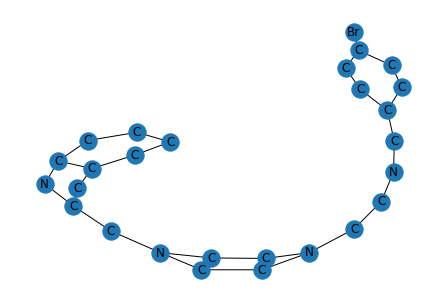

In [7]:
from pysmiles import read_smiles
import networkx as nx
    
smiles = chembl_dataset.smiles_list
mols = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols.append(read_smiles(chembl_dataset.smiles_list[i]))

mol = mols[0]
print(mol.nodes(data='element'))
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, labels = labels, pos=nx.spring_layout(mol))

Define edge index 

In [8]:
edge_index_list = []

for mol in tqdm(mols):
    adj = nx.to_scipy_sparse_matrix(mol).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_index_list.append(edge_index)

display(len(mols))

  0%|          | 0/8348 [00:00<?, ?it/s]

8348

Define torchdrug dataset in order to get node features

In [9]:
mols_torchdrug_format = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(chembl_dataset.smiles_list[i], with_hydrogen = False))


  0%|          | 0/8348 [00:00<?, ?it/s]

c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)


## Create Custom Dataset

In [10]:
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_list = []
y = torch.LongTensor(chembl_dataset.targets["label"]).to(device)

for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], smiles = chembl_dataset.smiles_list[i]))


  0%|          | 0/8348 [00:00<?, ?it/s]

In [11]:
class ChEMBLDatasetPyG(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_list = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        #self.data, self.slices = torch.load(self.processed_paths[0])
        self.data_list = data_list

        # Read data into huge `Data` list.
        data_list = self.data_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.data, self.slices = self.collate(data_list)
        

In [12]:
dataset = ChEMBLDatasetPyG(".", data_list = data_list)

Split data in train/val/test (0.8/0.1/0.1)

In [13]:
lengths = [int(0.8 * len(chembl_dataset)), int(0.1 * len(chembl_dataset))]
lengths += [len(chembl_dataset) - sum(lengths)]

print(lengths)
dataset = dataset.shuffle()
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] + 1: ]  #we add +1 otherwise the last sample of the validation falls in the test too.
len(train_data), len(val_data), len(test_data)

[6678, 834, 836]


(6678, 834, 836)

In [14]:
batch_size= 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [15]:
for i in range(len(train_data)):
    print(train_data[i].smiles)

O=C(NC1CCC(CCN2CCC(c3cccc4c3CCO4)CC2)CC1)c1ccc(N2CCOCC2)nc1
COc1ccccc1COc1ccc(S(=O)(=O)N2CCCC(C)(O)C2C(=O)NO)cc1
CC[n+]1ccc(CCC(=O)C2Cc3cc(OC)c(OC)cc3S2)cc1
O=C(Nc1ccc(CCN2CCN(c3ccccc3)CC2)cc1)Nc1cccnc1
CC#CCOc1cnc(C2=Nc3cc(C4(C)CC(C(F)(F)F)OC(N)=N4)c(F)cc3CN2)cn1
CCCN1CCN(c2ccc(O)c3[nH]c(=O)ccc23)CC1
CCCC=C1Oc2ccc(F)cc2-c2ccc3c(c21)C(C)=CC(C)(C)N3
Oc1ccc2c(c1)CCCNCCc1ccccc1C2
CN1CCN(C2=Nc3cc(Cl)ccc3N(NC(=O)c3nccc4ccccc34)c3ccccc32)CC1
Fc1ccc(CCCCN2CCN(c3ccc(Cl)cc3)CC2)cc1
CS(=O)(=O)c1ccc(-c2c(-c3ccc(F)cc3)noc2Cl)cc1
CC(C)(C)c1nc(N2CCN(CCCCn3c(=O)ccc4ccccc43)CC2)cc(C(F)(F)F)n1
[O-][S+](CCCN1CCN(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1
CCOC(=O)c1cccc(NC(=O)Nc2cccc3ccc(O)cc23)c1
CCCN1CCOC2c3cc(OCCCCNC(=O)c4ccc5scnc5c4)ccc3OCC21
Cc1c(F)cccc1Cc1c(C(=O)N2CCNCC2)c2ccc(O)cc2n1-c1ccccc1
COc1ccc(-c2ccc(OCCN3CCCC3C(=O)O)c(Sc3cccc(F)c3)c2)cc1
CC(O)C(N)c1nc2cc(-c3ccc(C#N)cc3)ccc2[nH]1
COc1c(OC)c(OC)c2c(c1O)c(=O)c1cccc(O)c1n2C
COc1ccc(-c2nc(O)c3ccccc3n2)cc1OC
CS(=O)(=O)N1CCN(C(=O)c2ccc(NC(=O)NC34CC5CC(CC(C5)C3

In [16]:
for i in range(len(val_data)):
    print(val_data[i].smiles)

O=C1CC(CN2CCC(C(=O)c3ccc(F)cc3)CC2)Cc2ncncc21
CCOc1cc(C=C(C#N)c2[nH]nc(N)c2C#N)ccc1O
O=C(NCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc(C#Cc2ccccc2)cc1
CCCCc1cc2c(s1)CC1c3cc(O)c(OC)cc3CCN1C2
O=C1NCCc2ccc(OCCCN3CCCN(c4cccc(Cl)c4Cl)CC3)cc21
CCC(=O)Oc1c(OC)ccc2c1CN1CCc3cc4c(cc3C1C2)OCO4
COc1cc(-c2ccc(F)c(C)c2)ccc1-n1c(=O)ccc2cc(S(=O)(=O)Nc3ccon3)ccc21
CCCN(CCN1CCN(Cc2cc3ccccc3[nH]2)CC1)c1ccc(Br)cc1
COc1ccc2[nH]c(C(=O)NCC=CCN3CCN(c4ccccc4OC)CC3)cc2c1
COc1cc2c(cc1OC)C1CC(N)C(N3CCC(C)CC3=O)CN1CC2
O=C1NCc2cc(F)c(OCCCCN3CCN(c4cccc5ccccc45)CC3)cc21
CC(C)(C)c1nc(N2CCN(CCCCN3C(=O)CC(=O)c4ccccc43)CC2)cc(C(F)(F)F)n1
CCOc1cccc(C(=O)NNS(=O)(=O)c2c(F)cccc2OC)c1
CC(C)Oc1ccc2[nH]cc(C3=CCN(Cc4ccccc4)CC3)c2c1
CCOc1ccc(S(=O)(=O)NCC(C)O)cc1-c1nnc2c(n1)c(C)nn2-c1ccc(C)cc1
COc1ccc(C(c2c(O)cc(C)oc2=O)c2c(O)cc(C)oc2=O)cc1
Fc1ccc(CN2CCC(Nc3ccc(C(F)(F)F)nn3)CC2)cc1F
COc1ccc(C(=O)C=Cc2ccccc2F)cc1
O=C(NC1CCC(CCN2CCN(c3cccc4c3OCO4)CC2)CC1)c1ccc2c(c1)OCCO2
CN1C(=N)NC2(c3cc(NC(=O)c4nccc5cc(Br)cnc45)ccc3F)CCCC2S1(=O)=O
COc1ccccc1N1

In [17]:
for i in range(len(test_data)):
    print(test_data[i].smiles)

CCOC(=O)c1c(C)nn(-c2ccccc2Cl)c1C
CN(Cc1cccc(-c2cnc(N3CCS(=O)(=O)CC3)nc2)c1)C(=O)CN
CNC(=O)CN1CN(c2ccccc2)C2(CCN(Cc3cc4c(cc3Cl)OCO4)CC2)C1=O
O=C1CCc2ccc(OCCCCN3CCN(c4ccccc4Cl)CC3)nc2N1
CN1C(=O)SC(=Cc2cc(OCc3cnc(NCc4ccccn4)nc3)c(O)cc2Br)C1=O
O=C1N(CCN2Cc3ccccc3C2)CCN1c1cc(Cl)ccc1F
Cc1cccc(-c2ccc3c(c2)C(N2CCN(C)CC2)Cc2ccccc2S3)c1C
Clc1ccc(N2CCCN(CCCc3cc4ccccc4o3)CC2)cc1
CCCN(CCCCNC(=O)c1ccc(-c2ccccc2)cc1)C1CCc2c(cccc2C(N)=O)C1
CN1C(=O)c2ccccc2[S+]([O-])c2ccc(C(=O)NCCN3CCCC3)cc21
CCC(=O)NC(=S)Nc1cccc(Cl)c1N1CCCCC1
CCCOc1ccc(S(=O)(=O)N2CCN(C)CC2)cc1-c1nc(C)c(Br)c(=O)[nH]1
O=C1NCc2ccc(OCCCN3CCN(c4cccc5c4CCO5)CC3)cc21
OC1(c2cccc(C(F)(F)F)c2)CCN(Cc2c[nH]c3ccccc23)CC1
CCNc1nc2[nH]c(O)cc(=O)c2s1
COc1cc(-c2cc(F)cc(F)c2)c(C#N)cc1-c1nccc2cc(S(=O)(=O)Nc3ccon3)ccc12
COc1ccc(CN2CCC(Nc3nc4ccc(NC(=N)c5cccs5)cc4s3)CC2)cc1
CCCCC(Sc1nc(Cl)cc(Nc2nc(-c3ccc(Cl)cc3)cs2)n1)C(=O)O
CCOc1cccc(-c2ccc(NC(=O)C(C#N)=C(O)CC)cc2C(=O)OC)c1
O=C1C2C3CCC(C3)C2C(=O)N1CCCCCCN1CCN(c2cccc(Cl)c2Cl)CC1
CCN(C)c1ncc(C)c(N2CCC(Oc3cc

## GCN Definition

In [15]:
from torch_geometric.nn import GCNConv, Linear
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(chembl_dataset.node_feature_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256).to(device)
print(model)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


## Load the Model

In [16]:
import os.path as osp

MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_model_" + str(MODEL_NUM) + ".ckpt"
ckpt_path = osp.join(MODEL_PATH)
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)

## Test the Model

In [17]:
def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_acc = test(test_loader)    
print(f'Test Acc: {test_acc:.4f}')

####THIS IS NOT THE TEST USED BY THE LOADED MODEL, WE NEED TO BE COHERENT AND USE THE SAME TRAIN,VAL AND TEST SETS############## TODO later, the focus now in explainability

Test Acc: 0.9988


## GraphSHAPer

* Players = edges
* Value = predicted probability $v$
* $E$ = set of all edges
* $v(E)$ = value of all the edges == original predicted prob
* $\phi_m(v)$ = payout for the contribution of edge m
* $S$ = all the possible subset of edges excluding m
* |S| = size of S
* $v(S)$ is the value achieved by subset S
* $v(S∪{m})$ is the realized value after m joins S

Shapley values compouted as:

$\phi_m(v) = \frac{1}{|E|} \sum_S \frac{v(S \cup {m}) - v(S)}{\binom{|E|-1}{|S|}}$

CN1CCN(c2ccc(C(=O)NC3CCC(CCN4CCC(c5cccc6c5CCO6)CC4)CC3)cc2)CC1
tensor([[ 4.1949, -3.9731]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[9.9972e-01, 2.8352e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0

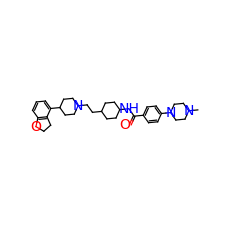

In [18]:
#test nums 78, 89, 2 is predicted to interact with target cpd, sample 0 is random for single target dataset with target 1. class 0 interacts, class 1 is random
# 78 is predicted to interact with target for dataset with target 2. 0 interacts with random
# for dual target Q9Y5N1_P31645 sample 0 has class 0
# for dual target P27338_P29274 sample 0 is class 0
# for dual targe P27338_P22303 sample 4 is class 0
test_set_index = 376
test_cpd = test_data[test_set_index].to(device)
print(test_cpd.smiles)
mol_test = data.Molecule.from_smiles(test_cpd.smiles, with_hydrogen=False)
mol_test.visualize()

model.eval()
# all nodes belong to same graph
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob = F.softmax(out, dim = 1)
target_class = torch.argmax(out_prob[0]).item()
print(out)
print(out_prob)
target_class

Creating folder and saving smiles

C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


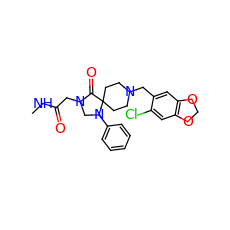

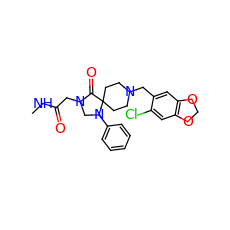

In [153]:
if SAVE:
    
    if DATASET_TYPE == "dual":
        FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS
    else:
        FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS +"/Target " + str(TARGET) + " vs Random"

    CPD_FOLDER_NAME = FOLDER_NAME + "/" + test_cpd.smiles

    if not os.path.exists(FOLDER_NAME):
        os.mkdir(FOLDER_NAME)

    if not os.path.exists(CPD_FOLDER_NAME):
        os.mkdir(CPD_FOLDER_NAME)


    mol_test.visualize(save_file = CPD_FOLDER_NAME + "/" + test_cpd.smiles + ".png")

mol_test.visualize()

In [19]:
print(test_cpd.edge_index)
print(test_cpd.edge_index.shape)

tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 15, 15,
         15, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 20, 21, 21, 21, 22, 22, 22,
         23, 23, 24, 24, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30,
         31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38],
        [ 1,  0,  2, 38,  1,  3,  2,  4,  3,  5, 37,  4,  6, 36,  5,  7,  6,  8,
          7,  9, 35,  8, 10, 11,  9,  9, 12, 11, 13, 34, 12, 14, 13, 15, 14, 16,
         33, 15, 17, 16, 18, 17, 19, 32, 18, 20, 19, 21, 20, 22, 31, 21, 23, 27,
         22, 24, 23, 25, 24, 26, 25, 27, 30, 22, 26, 28, 27, 29, 28, 30, 26, 29,
         21, 32, 18, 31, 15, 34, 12, 33,  8, 36,  5, 35,  4, 38,  1, 37]],
       device='cuda:0')
torch.Size([2, 88])


### Jackknife approx

* $S = E/\{m\}$
* $ v(S \cup {m}) = v(E)$ # since if we add m back we obtain the original graph

In [21]:
# from scipy.special import binom

# v_E = out_prob[0][target_class].item()
# E = test_cpd.edge_index
# phi_edges = []
# v_S_u_m = v_E

# for i in tqdm(range(E.shape[1])):
#     # node_source = E[0][i]
#     # node_to = E[1][i]
#     #S = E[0:,i:]
#     S = torch.cat([E[0:,0:i], E[0:,i+1:]], dim = 1)
#     batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
#     out = model(test_cpd.x, S, batch=batch) #we use S as edge index
#     out_prob = F.softmax(out, dim = 1)
#     v_S = out_prob[0][target_class].item()

#     denominator = binom(E.shape[1] - 1, 1)

#     shapley_value = (1/E.shape[1]) * ((v_S_u_m - v_S) / denominator) #jackknife approximation
#     phi_edges.append(shapley_value)

# sum(phi_edges)


In [22]:
# phi_edges

### Montecarlo Sampling

See https://christophm.github.io/interpretable-ml-book/shapley.html#estimating-the-shapley-value and https://link.springer.com/article/10.1007/s10115-013-0679-x

Inseatd of randmly sampling sample $z$ from the data (that for use is nonsense) we create a random graph $Z$ according to a problability distribution.
We add an edge according to the probability of an edge to exists in the explained graph G.

Pseudo code:

Output: Shapley value for j-th edge
Required: number of iterations M, graph to explain $G(N_g, E_g)$, edge list E, edge index j, edge_probability_distribution, GNN model

$\forall\space m \in {0,...,M-1}$

* create random graph $Z(N_z,E_z)$, where $N_z = N_g$ and with $E_z$ are such that $z \in E_z | e \sim \mathbf{P}$, where $\mathbf{P}$ is the probablity distrubution of an edge to exist. (can be domain-specific, depends on atoms!)
* Choose a random permutation $\pi$ of the egdes
* Order edges list $E_g$: $E_g^{\phi}: (e_0,...,e_j,...,e_{|E_g|-1})$
* Order edges list $E_z$: $E_z^{\phi}: (z_0,...,z_j,...,z_{|E_z|-1})$
* Constuct the two new edge lists:
    * With index $j: E_{+j} = (e_0,...,e_j,z_{j+1}...,z_{|E_z|-1})$
    * Without index $j: E_{-j} = (e_0,...,e_{j-1}, z_j,z_{j+1}...,z_{|E_z|-1})$
* Compute marginal contribution: $\phi_j^m = \hat{f}(E_{+j}) - \hat{f}(E_{+j})$
* Compute Shapley values as the avb: $\phi_j(G) = \frac{1}{M} \sum_{m=0}^{M-1} \phi_{j}^{m}$

where $\hat{f}$ is the function learned by the GNN

number of max edges in directed graph: n*(n-1)

number of max edges in undirected graph: (n*(n-1))/2

### Define edge probablility
We approximate it by using the graph desinity. This is a rather brutal approximation, a domain-specific approach would work probably better (e.g. atoms involved etc)

In [146]:
E = test_cpd.edge_index
num_nodes = test_cpd.x.shape[0]
max_num_edges = num_nodes*(num_nodes-1)
num_edges = E.shape[1]
graph_density = num_edges/max_num_edges
P = graph_density #this is to be discussed

In [147]:
M = 100
phi_edges = []
# marginal_contrib = 0
from numpy.random import default_rng
rng = default_rng(seed = 42) #to seed or not to seed?
model.eval()

log_odds = False
for j in tqdm(range(num_edges)):
    marginal_contrib = 0
    for i in range(M):
        E_z_mask = rng.binomial(1, P, num_edges)
        #E_z_index = torch.IntTensor(torch.nonzero(torch.IntTensor(E_z_mask)).tolist()).to(device).squeeze()
        #E_z = torch.index_select(E, dim = 1, index = E_z_index)
        E_mask = torch.ones(num_edges)
        pi = torch.randperm(num_edges)

        E_j_plus_index = torch.ones(num_edges, dtype=torch.int)
        E_j_minus_index = torch.ones(num_edges, dtype=torch.int)
        selected_edge_index = np.where(pi == j)[0].item()
        for k in range(num_edges):
            if k <= selected_edge_index:
                E_j_plus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_plus_index[pi[k]] = E_z_mask[pi[k]]

        for k in range(num_edges):
            if k < selected_edge_index:
                E_j_minus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_minus_index[pi[k]] = E_z_mask[pi[k]]


        #we compute marginal contribs
        
        # with edge j
        retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
        E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        
        out = model(test_cpd.x, E_j_plus, batch=batch)
        out_prob = None

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out #out prob variable now containts log_odds
        
        V_j_plus = out_prob[0][target_class].item() #probably the predicted class changes when selecting/deselecing certain edges for class 1: more iterations needed?

        # without edge j
        retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
        E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        out = model(test_cpd.x, E_j_minus, batch=batch)

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out
        
        V_j_minus = out_prob[0][target_class].item()

        marginal_contrib += (V_j_plus - V_j_minus)

    phi_edges.append(marginal_contrib/M)     
         
sum(phi_edges)

  0%|          | 0/74 [00:00<?, ?it/s]

1.00577806284189

In [148]:
print(out_prob)
print(phi_edges)

tensor([[8.2602e-09, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[-0.006205943231092107, -0.013643475442562204, 0.019585820354095514, 0.040370309016611386, 0.07540229741698207, -0.02433276445347004, -0.059593423301726955, 0.03677082211748142, -0.008207261833289093, 0.016467789992926436, -0.018133246390282506, 0.028499816980789877, 0.006277069913198619, 0.03645847649328841, -0.01777840753823781, -0.020648258070879857, 0.014929854359372448, 0.0003951103626661307, 0.01823034189854896, -0.0019728440948435884, 0.019411424848294046, 0.006368332311483429, -0.0020907053674368648, -0.011788460098811565, 0.01052160655659247, -0.004236856477665408, 0.00956876685463622, 0.005877447387316158, -0.00687709522105507, 0.0011439825992835952, -0.010960866242605722, -0.026332790177596436, -0.0018023915740959548, -0.0051123132298826176, 0.017058912375840337, -0.007047644002542029, 0.08327785984068369, 0.004214236098047203, 0.1755940889452697, 0.09496229326611724, 0.23695975323516077, -0.0013

In [154]:
if SAVE:

    with open(CPD_FOLDER_NAME + "/info_explanations.txt", "w+") as saveFile:
        saveFile.write("Test set index: " + str(test_set_index) + "\n\n")

    with open(CPD_FOLDER_NAME + "/info_explanations.txt", "a") as saveFile:
        saveFile.write("Target Class: " + str(target_class) + "\n\n")

    tagert_compound_sample = "TARGET" if target_class == 0 else "RANDOM"

    with open(CPD_FOLDER_NAME + "/info_explanations.txt", "a") as saveFile:
        saveFile.write("Target compound: " + str(tagert_compound_sample) + "\n\n")

    with open(CPD_FOLDER_NAME + "/info_explanations.txt", "a") as saveFile:
        saveFile.write("Sum of Shapley Values: " + str(sum(phi_edges)) + "\n\n")

    with open(CPD_FOLDER_NAME + "/info_explanations.txt", "a") as saveFile:
        saveFile.write("Shapley values:\n")
        for phi_val in phi_edges:
            saveFile.write(str(phi_val) + "\n")

In [28]:
# retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
# E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_plus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_plus = out_prob[0][0].item()

# # without edge j
# retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
# E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_minus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_minus = out_prob[0][0].item()

# marginal_contrib += (V_j_plus - V_j_minus)

In [29]:
# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
# out_prob = F.softmax(out, dim = 1)

## Visualize Explanation

[40 38 67 39 36  4 68 72 53  3  7 13 55 11 58 73 42  2 20 63 50 18 46 34
  9 62 16 45 24 26 21 12 27 47 37 65 61 29 49 54 17 60 41 32 19 22 44 48
 66 25 33 69 64  0 52 28 35  8 51 30 23  1 71 57 14 10 15 56  5 31 70 59
 43  6]
[0.23695975323516077, 0.1755940889452697, 0.12683050835062062, 0.09496229326611724, 0.08327785984068369, 0.07540229741698207, 0.06942581887540916, 0.05340398810471654, 0.044108243983780805, 0.040370309016611386, 0.03677082211748142, 0.03645847649328841, 0.035464090057949045, 0.028499816980789877, 0.027845028728465473, 0.023115008182021078, 0.021222283693926522, 0.019585820354095514, 0.019411424848294046, 0.019166104405022685, 0.018766870779356612, 0.01823034189854896, 0.017931691545594444, 0.017058912375840337, 0.016467789992926436, 0.01557856755757335, 0.014929854359372448, 0.011975406051849501, 0.01052160655659247, 0.00956876685463622, 0.006368332311483429, 0.006277069913198619, 0.005877447387316158, 0.004378201911980503, 0.004214236098047203, 0.003492365328020

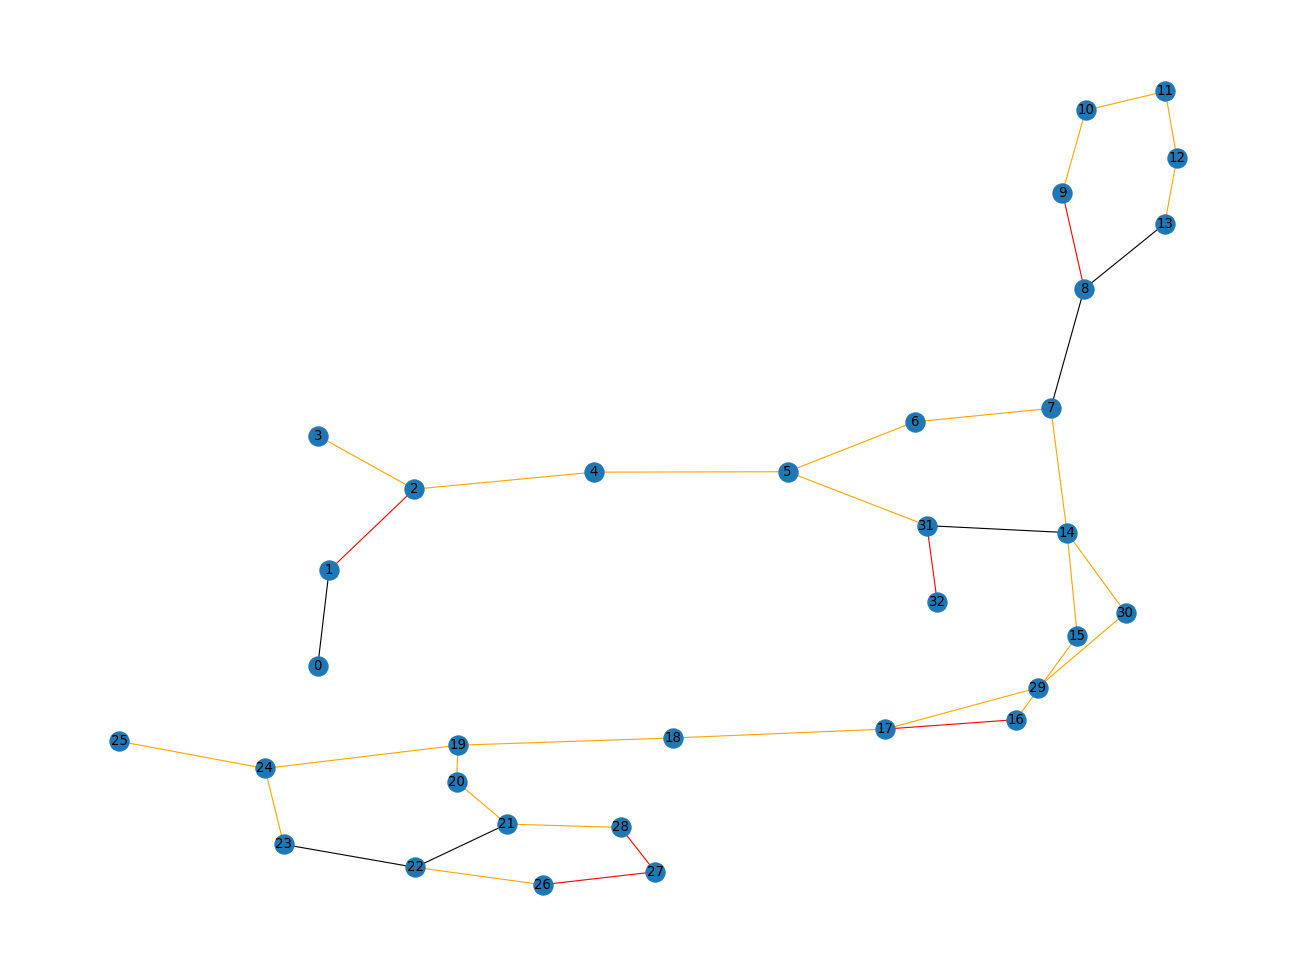

In [157]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

important_edges_ranking = np.argsort(-np.array(phi_edges))
print(important_edges_ranking)
sorted_phi_edges = sorted(phi_edges, reverse = True)
print(sorted_phi_edges)
print(sum(phi_edges))

threshold = np.median(phi_edges) #to discuss when an edge in important or not
hard_edge_mask = (torch.FloatTensor(phi_edges) > threshold).to(torch.float) #>=
print(hard_edge_mask.shape)

important_edges_index = torch.nonzero(hard_edge_mask == 1)
print(important_edges_index)

edge_index = E.to(device)
important_edges_index = important_edges_index.to(device)

important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
print(important_edges)

edges_color = []
mol = read_smiles(test_cpd.smiles)

#standard visualization for importan egdes GNNExplainer-like
for edge in mol.edges:
    found_from = False
    found_to = False
    for i in range(important_edges.shape[1]):
        if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
            found_from = True
        if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
            found_to = True
    if found_from and found_to:
        edges_color.append("red")
    elif found_from or found_to:
        edges_color.append("orange")
    else:
        edges_color.append("black")   

#visualization for indentifying unimportant edges (edge is important if both directins are above threshold)
# for edge in mol.edges:
#     found_from = False
#     found_to = False
#     for i in range(important_edges.shape[1]):
#         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
#             found_from = True
#         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
#             found_to = True
#     if found_from and found_to:
#         edges_color.append("red")
#     # elif found_from or found_to:
#     #     edges_color.append("red")
#     else:
#         edges_color.append("black")   

figure(figsize=(16, 12), dpi=80)
#mol = nx.DiGraph(mol)
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

if SAVE:
    plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M), dpi=300, bbox_inches='tight')
    
plt.show()

## GNNExplainer
Explain the classification of a test cpd using GNNExplainer

In [158]:
import os.path as osp

import torch
import torch.nn.functional as F


from torch_geometric.nn import GNNExplainer

torch.manual_seed(42)
epochs = 100
# test_cpd = test_data[0].to(device)

#model = Net().to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index, edge_weight = test_cpd.x, test_cpd.edge_index, None

explainer = GNNExplainer(model, epochs=epochs, return_type='log_prob')

node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

Explain graph: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


### Plot Explaination Subgraph

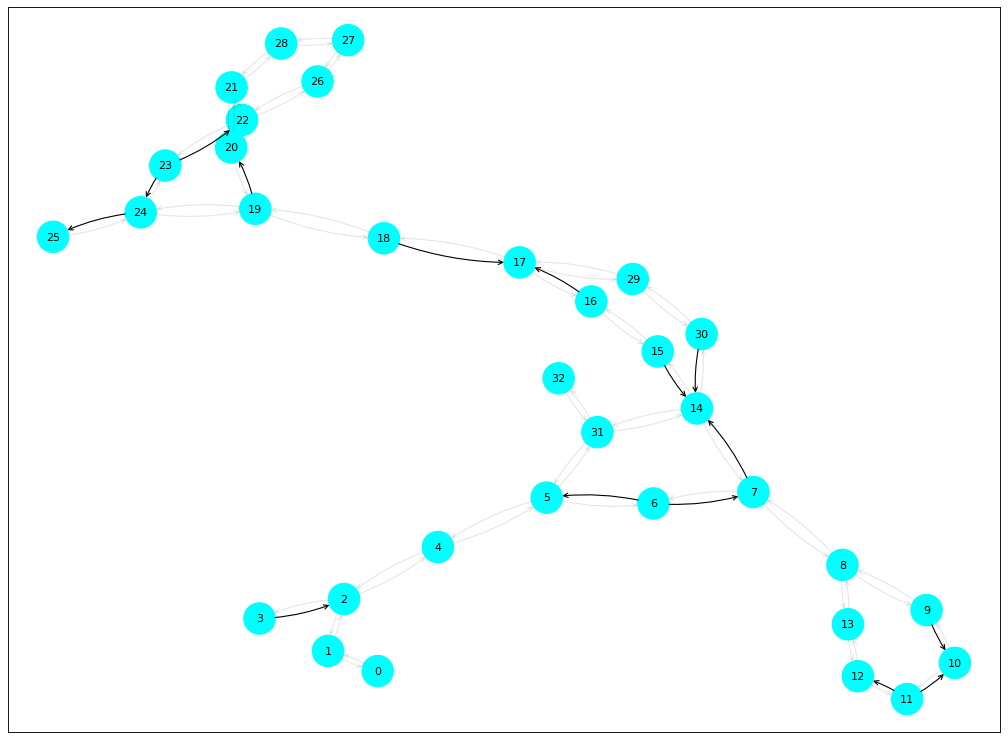

In [159]:
from matplotlib.pyplot import figure

figure(figsize=(16, 12), dpi=80)
threshold = 0.75
edge_mask = edge_mask.to("cpu")
ax, G = explainer.visualize_subgraph(edge_index = edge_index, edge_mask = edge_mask, node_idx = -1, y=None, threshold=threshold)

if SAVE:
    plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GNNExplainer_viz0", dpi=300, bbox_inches='tight')

plt.show()

tensor([[ 6],
        [12],
        [13],
        [16],
        [21],
        [24],
        [25],
        [34],
        [37],
        [41],
        [44],
        [54],
        [55],
        [58],
        [68]])
tensor([[ 3,  6,  6,  7,  9, 11, 11, 15, 16, 18, 19, 23, 23, 24, 30],
        [ 2,  5,  7, 14, 10, 10, 12, 14, 17, 17, 20, 22, 24, 25, 14]],
       device='cuda:0')


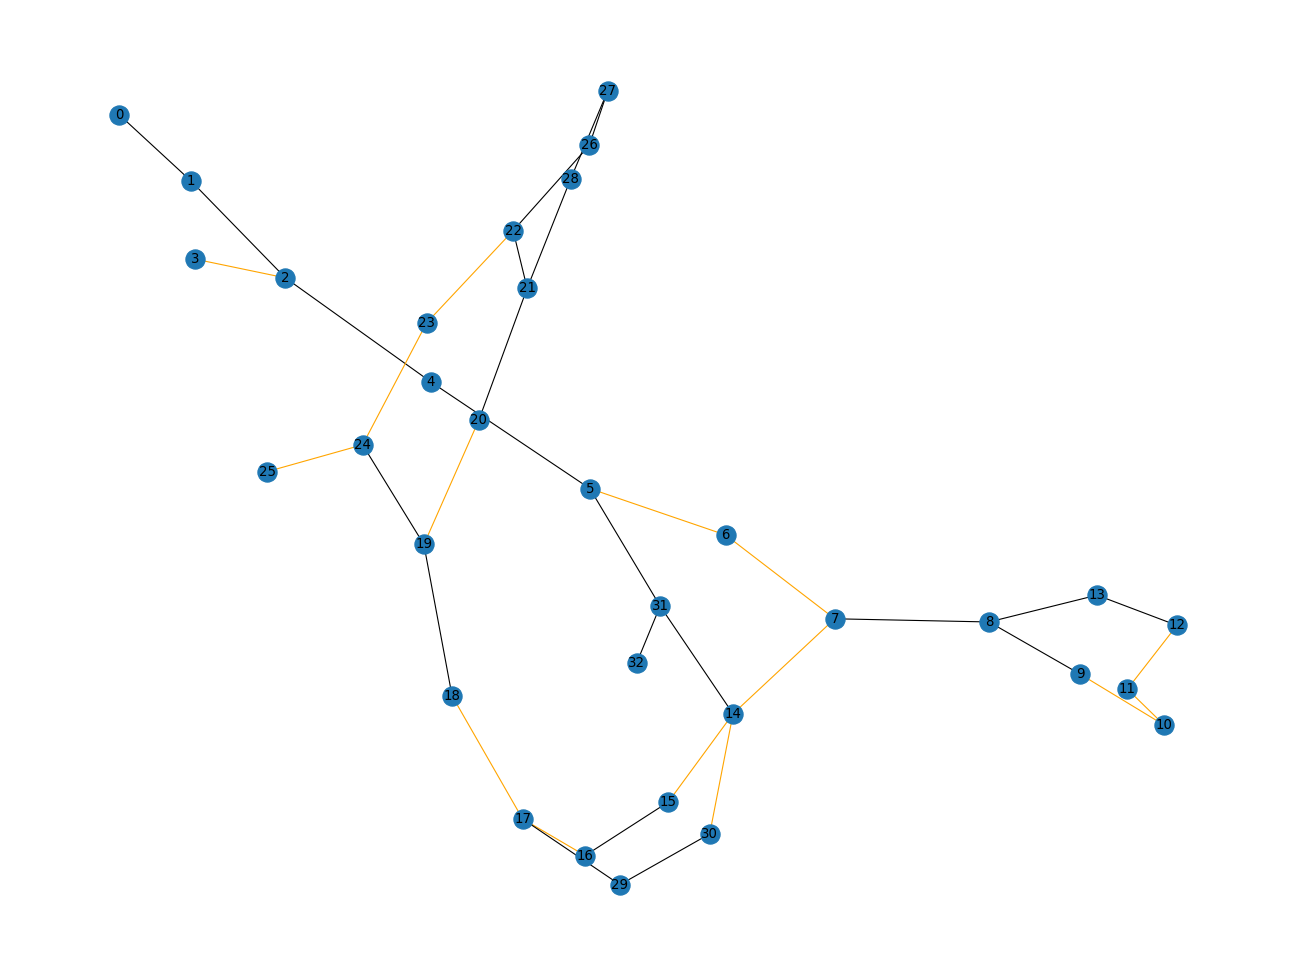

In [160]:
hard_edge_mask = (edge_mask >= threshold).to(torch.float)
hard_edge_mask.shape

important_edges_index = torch.nonzero(hard_edge_mask == 1)
print(important_edges_index)

edge_index = edge_index.to(device)
important_edges_index = important_edges_index.to(device)

important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
print(important_edges)

edges_color = []
mol = read_smiles(test_cpd.smiles)

for edge in mol.edges:
    found_from = False
    found_to = False
    for i in range(important_edges.shape[1]):
        if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
            found_from = True
        if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
            found_to = True
    if found_from and found_to:
        edges_color.append("red")
    elif found_from or found_to:
        edges_color.append("orange")
    else:
        edges_color.append("black")   

figure(figsize=(16, 12), dpi=80)
#mol = nx.DiGraph(mol)
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

if SAVE:
    plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GNNExplainer_viz1", dpi=300, bbox_inches='tight')

plt.show()

## Pertinent Positive/Negative Set

### pertinent negative

In [150]:
pertinent_set_indices = []
pertinent_set_edge_index = None
edge_index = E.to(device)
print("Complete graph predicts class: ", target_class)

model.eval()
for i in range(important_edges_ranking.shape[0]):
    index_of_edge_to_remove = important_edges_ranking[i]
    pertinent_set_indices.append(index_of_edge_to_remove)

    reduced_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(important_edges_ranking[i:]).to(device))
    
    # all nodes belong to same graph
    batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
    out = model(test_cpd.x, reduced_edge_index, batch=batch)
    out_prob = F.softmax(out, dim = 1)
    print(out_prob)
    predicted_class = torch.argmax(out_prob[0]).item()

    if predicted_class != target_class:
        break

pertinent_set_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(pertinent_set_indices).to(device))
print(pertinent_set_indices)
print(pertinent_set_edge_index)

Complete graph predicts class:  0
tensor([[0.9859, 0.0141]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.0035, 0.9965]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[40, 38]
tensor([[17, 17],
        [29, 16]], device='cuda:0')


### pertinent positive

In [151]:
for i in range(important_edges_ranking.shape[0]+1):
    reduced_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(important_edges_ranking[0:i]).to(device))
    batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
    out = model(test_cpd.x, reduced_edge_index, batch=batch)
    out_prob = F.softmax(out, dim = 1)
    # print(out_prob)
    predicted_class = torch.argmax(out_prob[0]).item()
    if (predicted_class == target_class):
        print(i)
        print(reduced_edge_index)
        print(out_prob)
        break

35
tensor([[17, 17, 29, 17, 16,  2, 30, 31, 22,  2,  4,  6, 23,  5, 24, 32, 18,  1,
          9, 27, 21,  8, 20, 15,  5, 27,  7, 19, 11, 12,  9,  6, 12, 20, 16],
        [29, 16, 30, 18, 15,  3, 14, 32, 26,  1,  2,  7, 24, 31, 25, 31, 19,  2,
          8, 28, 28,  9, 19, 14,  4, 26, 14, 24, 10, 11, 10,  5, 13, 21, 17]],
       device='cuda:0')
tensor([[9.9998e-01, 2.2059e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
